## NLDAS daily averages

In [7]:
# Directories
nldas_dir = "/storage/group/pches/default/public/NLDAS"
log_dir = "/storage/home/dcl5300/work/current_projects/wbm_soilM_crop_uc_lafferty-etal-2024-tbd/code/logs"

In [8]:
def calculate_nldas_daily_avg(date, model, nldas_dir, out_dir, log_dir):

    # Remove dashes
    date_strf = date.strftime("%Y-%m-%d").replace('-','')
    
    # Check if done
    if os.path.isfile(f"{out_dir}/NLDAS_{model}0125_H.A{date_strf}.nc"):
        return None
        
    # Read entire day (check if complete)
    files = glob.glob(f'{nldas_dir}/NLDAS_{model}0125_H.A{date_strf}*')
    if len(files) != 24:
        with open(f'{log_dir}/NLDAS_{model}0125_H_{date_strf}.txt', 'w') as f:
            f.write(f'Only {len(files)} files')
            return None
    
    # Auto-combine
    ds = xr.concat([xr.open_dataset(file) for file in files], dim='time')

    # Resample to daily
    if model == 'FORA':
        ds_apcp = xr.Dataset({'APCP': ds['APCP'].resample(time='1D').sum()})
        ds_tmp = xr.Dataset({'TMP': ds['TMP'].resample(time='1D').mean()}).isel(height=0).drop('height')

        # Merge
        ds_out = xr.merge([ds_apcp, ds_tmp])
    else:
        ds_out = ds.resample(time='1D').mean()

    # Store 
    ds_out.to_netcdf(f"{out_dir}/NLDAS_{model}0125_H.A{date_strf}.nc")

In [9]:
%%time
# Define dates
start_date = date(2016, 1, 1)
end_date = date(2022, 12, 31)
delta = timedelta(days=1)

# Loop for dask delayed
delayed = []
while start_date <= end_date:
    delayed.append(dask.delayed(calculate_nldas_daily_avg)(date=start_date,
                                                           model = 'FORA',
                                                           nldas_dir=f'{nldas_dir}/forcing/hourly',
                                                           out_dir=f'{nldas_dir}/forcing/daily/',
                                                           log_dir=log_dir))
    start_date += delta

# Compute
_ = dask.compute(*delayed)

CPU times: user 6.5 s, sys: 433 ms, total: 6.93 s
Wall time: 31.6 s


## SMAP daily averages

In [5]:
# Directories
in_dir = "/storage/group/pches/default/public/SMAP/raw_nc"
out_dir = "/storage/group/pches/default/public/SMAP/processed"
log_dir = "/storage/home/dcl5300/work/current_projects/wbm_soilM_crop_uc_lafferty-etal-2024-tbd/code/logs"

In [17]:
def calculate_daily_avg(date, in_dir, out_dir, log_dir):
    def _preprocess(ds):
        # Add datetime
        dt_all = ds.encoding["source"][63:78]
        datetime = pd.to_datetime(f"{dt_all[:4]}-{dt_all[4:6]}-{dt_all[6:8]} {dt_all[9:11]}:30", format="%Y-%m-%d %H:%M")
        ds = ds.expand_dims(time=[datetime])
        # Select band data
        ds = ds.isel(band=0)
        # Rename coords
        ds = ds.rename({'x':'lon', 'y':'lat'})
        # Rename var
        var_list = ds.encoding["source"].split('_sm_')[1].split('_')
        
        if len(var_list) == 2:
            var_name = f'sm_{var_list[0]}'
        elif len(var_list) == 3:
            var_name = f'sm_{var_list[0]}_{var_list[1]}'

        ds = ds.rename({'band_data':var_name})
        
        # Drop unwanted vards
        ds = ds.drop_vars(['band','spatial_ref'])
        # Return
        return ds

    # Remove dashes
    date_strf = date.strftime("%Y-%m-%d").replace('-','')
    
    # Check if done
    if os.path.isfile(f"{out_dir}/SMAP_L4_SM_gph_all_{date_strf}.nc"):
        return None
        
    # Read entire day (check if complete)
    files = glob.glob(f'{in_dir}/SMAP_L4_SM_gph_{date_strf}*.tif')
    if len(files) != 8*4:
        with open(f'{log_dir}/SMAP_L4_SM_gph_{date_strf}.txt', 'w') as f:
            f.write(f'Only {len(files)} files')
            return None
    
    # Auto-combine
    ds = xr.combine_by_coords([_preprocess(xr.open_dataset(file)) for file in files])

    # Resample to daily means
    ds_out = ds.resample(time='1D').mean()

    # Store 
    ds_out.to_netcdf(f"{out_dir}/SMAP_L4_SM_gph_all_{date_strf}.nc")

In [19]:
%%time
# Define dates
start_date = date(2016, 1, 1)
# end_date = date(2016, 12, 31)
end_date = date(2022, 12, 31)
delta = timedelta(days=1)

# Loop for dask delayed
delayed = []
while start_date <= end_date:
    delayed.append(dask.delayed(calculate_daily_avg)(date=start_date,
                                                     in_dir=in_dir,
                                                     out_dir=out_dir,
                                                     log_dir=log_dir))
    start_date += delta

# Compute
_ = dask.compute(*delayed)

CPU times: user 10.7 s, sys: 551 ms, total: 11.2 s
Wall time: 53.5 s


### Re-grid to NLDAS grid

In [5]:
# Directories
in_dir = "/storage/group/pches/default/public/SMAP/processed"
out_dir = "/storage/group/pches/default/public/SMAP/processed_nldas_grid"

In [6]:
# Get NLDAS grid
nldas_grid = xr.open_dataset('/storage/group/pches/default/public/NLDAS/forcing/daily/NLDAS_FORA0125_H.A20221231.nc') # random date

nldas_lon_grid = nldas_grid.lon.to_numpy()
nldas_lat_grid = nldas_grid.lat.to_numpy()

In [7]:
def regrid_to_nldas(date, nldas_lon_grid, nldas_lat_grid, in_dir, out_dir):
    # Remove dashes
    date_strf = date.strftime("%Y-%m-%d").replace('-','')
    
    # Check if done
    if os.path.isfile(f"{out_dir}/SMAP_L4_SM_gph_all_nldas_{date_strf}.nc"):
        return None
        
    # Read
    dr_in = xr.open_dataset(f"{in_dir}/SMAP_L4_SM_gph_all_{date_strf}.nc")
    dr_in = dr_in.sortby('lat').sel(lat=slice(20,60), lon=slice(-130,-60)) # generous North America slice
    
    # Regrid conservatively
    ds_out = xr.Dataset(
        {
        "lat": (["lat"], nldas_lat_grid, {"standard_name": "latitude", "units": "degrees_north"}),
        "lon": (["lon"], nldas_lon_grid, {"standard_name": "longitude", "units": "degrees_east"}),
        }
    )
    regridder = xe.Regridder(dr_in, ds_out, 'conservative')
    dr_out = regridder(dr_in)

    # Store 
    dr_out.to_netcdf(f"{out_dir}/SMAP_L4_SM_gph_all_nldas_{date_strf}.nc")

In [8]:
%%time
# Define dates
start_date = date(2016, 1, 1)
end_date = date(2022, 12, 31)
delta = timedelta(days=1)

# Loop for dask delayed
delayed = []
while start_date <= end_date:
    delayed.append(dask.delayed(regrid_to_nldas)(date=start_date,
                                                 nldas_lon_grid=nldas_lon_grid,
                                                 nldas_lat_grid=nldas_lat_grid,
                                                 in_dir=in_dir,
                                                 out_dir=out_dir))
    start_date += delta

# Compute
_ = dask.compute(*delayed)

CPU times: user 1min 28s, sys: 6.07 s, total: 1min 34s
Wall time: 9min 36s


### Plot

In [6]:
ds = xr.open_mfdataset('/storage/group/pches/default/public/SMAP/processed_nldas_grid/SMAP_L4_SM_gph_all_*.nc')

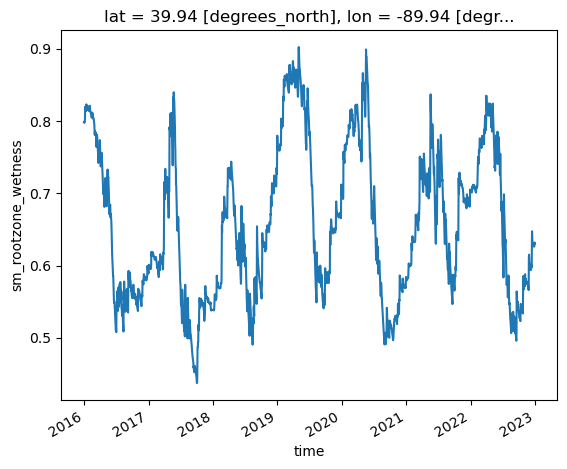

In [7]:
ds.sel(lat=40, lon=-90, method='nearest').sm_rootzone_wetness.plot()

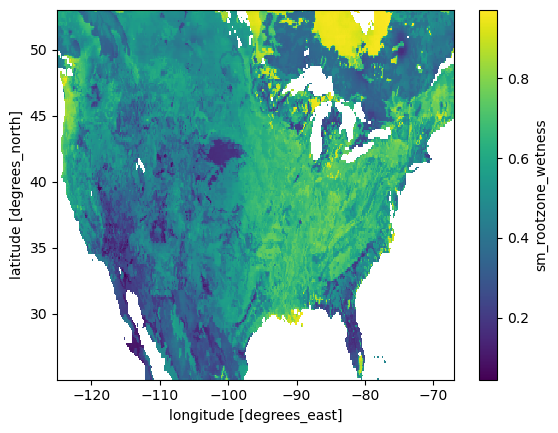

In [8]:
ds.sm_rootzone_wetness.mean(dim='time').plot()